In [58]:
from psycopg2 import connect
import pandas.io.sql as pandasql
import pandas as pd
import configparser
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib as mpl

CONFIG = configparser.ConfigParser()
CONFIG.read('C:\\Users\\rrodger\\reed.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [121]:
sql_15 = '''
WITH yr as (
    SELECT EXTRACT(YEAR FROM datetime_bin) as year, 
        analysis_id, 
        datetime_bin::time as time, 
        percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.tt) as yr_tt,
        EXTRACT(ISODOW FROM datetime_bin) as weekday,
        aa.report_name

    FROM bluetooth.aggr_15min bt

    GROUP BY analysis_id, 
        datetime_bin::time, 
        EXTRACT(YEAR FROM datetime_bin), 
        EXTRACT(ISODOW FROM datetime_bin))

SELECT bt.tt, 
	yr.yr_tt, 
	bt.datetime_bin, 
	bt.analysis_id,
	EXTRACT(ISODOW FROM datetime_bin) as weekday
    aa.
FROM bluetooth.aggr_15min bt
	INNER JOIN yr ON (yr.analysis_id = bt.analysis_id 
		AND EXTRACT(year FROM bt.datetime_bin) = yr.year 
		AND bt.datetime_bin::time = yr.time)
		AND EXTRACT(ISODOW FROM bt.datetime_bin) = yr.weekday
    INNER JOIN bluetooth.all_analyses aa ON (bt.analysis_id = aa.analysis_id)
WHERE left(aa.report_name, 4) = 'DT-0'
'''

observations_15 = pandasql.read_sql(sql, con)

In [109]:
start = pandas.Timestamp('2017-10-04 00:00:00')
end = pandas.Timestamp('2017-10-05 00:00:00')
colors = ['#0f6006', '#ce3bf7', '#ecf47a', '#3b86f7']

#(start <= observations.datetime_bin) & (observations.datetime_bin <= end)

#observations = observations.sort_values(['datetime_bin'])


In [116]:
def plot_base(observations):
    
    
    segments = {analysis_id:
            {'WD':
             observations[(observations['analysis_id'] == analysis_id) & 
                           (observations.weekday < 5)].sort_values(['datetime_bin']),
            'F':
             observations[(observations['analysis_id'] == analysis_id) & 
                           (observations.weekday == 5)].sort_values(['datetime_bin']),
            'Sa':
             observations[(observations['analysis_id'] == analysis_id) & 
                           (observations.weekday == 6)].sort_values(['datetime_bin']),
            'Su':
             observations[(observations['analysis_id'] == analysis_id) & 
                           (observations.weekday == 7)].sort_values(['datetime_bin'])}
            for analysis_id in observations['analysis_id'].unique()}
    
    fig, analysis = plt.subplots(5, 1, figsize = (16,64))
    handles = []
    for color, WD in zip(colors, ['F', 'Sa', 'Su', 'WD']):
        handles.append(mpl.patches.Patch(color = color, label = WD))
    weekday = []
#plot on the same x axis, based on time of day.
    for i, a_id in enumerate(segments): #plots five analysis_id graphs
        if i == 5:
            break
        analysis[i].plot_date(x = segments[a_id]['WD'].datetime_bin,
                             y = segments[a_id]['WD'].yr_tt,
                             xdate = True,
                             fmt = '-o',
                             c = colors[3])
        weekday.append([])
        for j, WD in enumerate(['F', 'Sa', 'Su']):
            weekday[i].append(analysis[i].twinx())
            weekday[i][j].plot_date(x = segments[a_id][WD].datetime_bin,
                                 y = segments[a_id][WD].yr_tt,
                                 xdate = True,
                                 fmt = '-o',
                                 c = colors[j])
            
            weekday[i][j].get_xaxis().set_visible(False)
            weekday[i][j].get_yaxis().set_visible(False)
        plt.title('Baseline for ' + observations['report_name'] + ' by Day')
        analysis[i].set_xlim(pd.Timestamp(2017, 10, 26, 0, 0, 0), pd.Timestamp(2017, 10, 30, 0, 0))
        analysis[i].legend(title = 'Day', handles = handles)
        analysis[i].xaxis.set_label_text('Time')
        analysis[i].yaxis.set_label_text('Travel Time')
    plt.show()

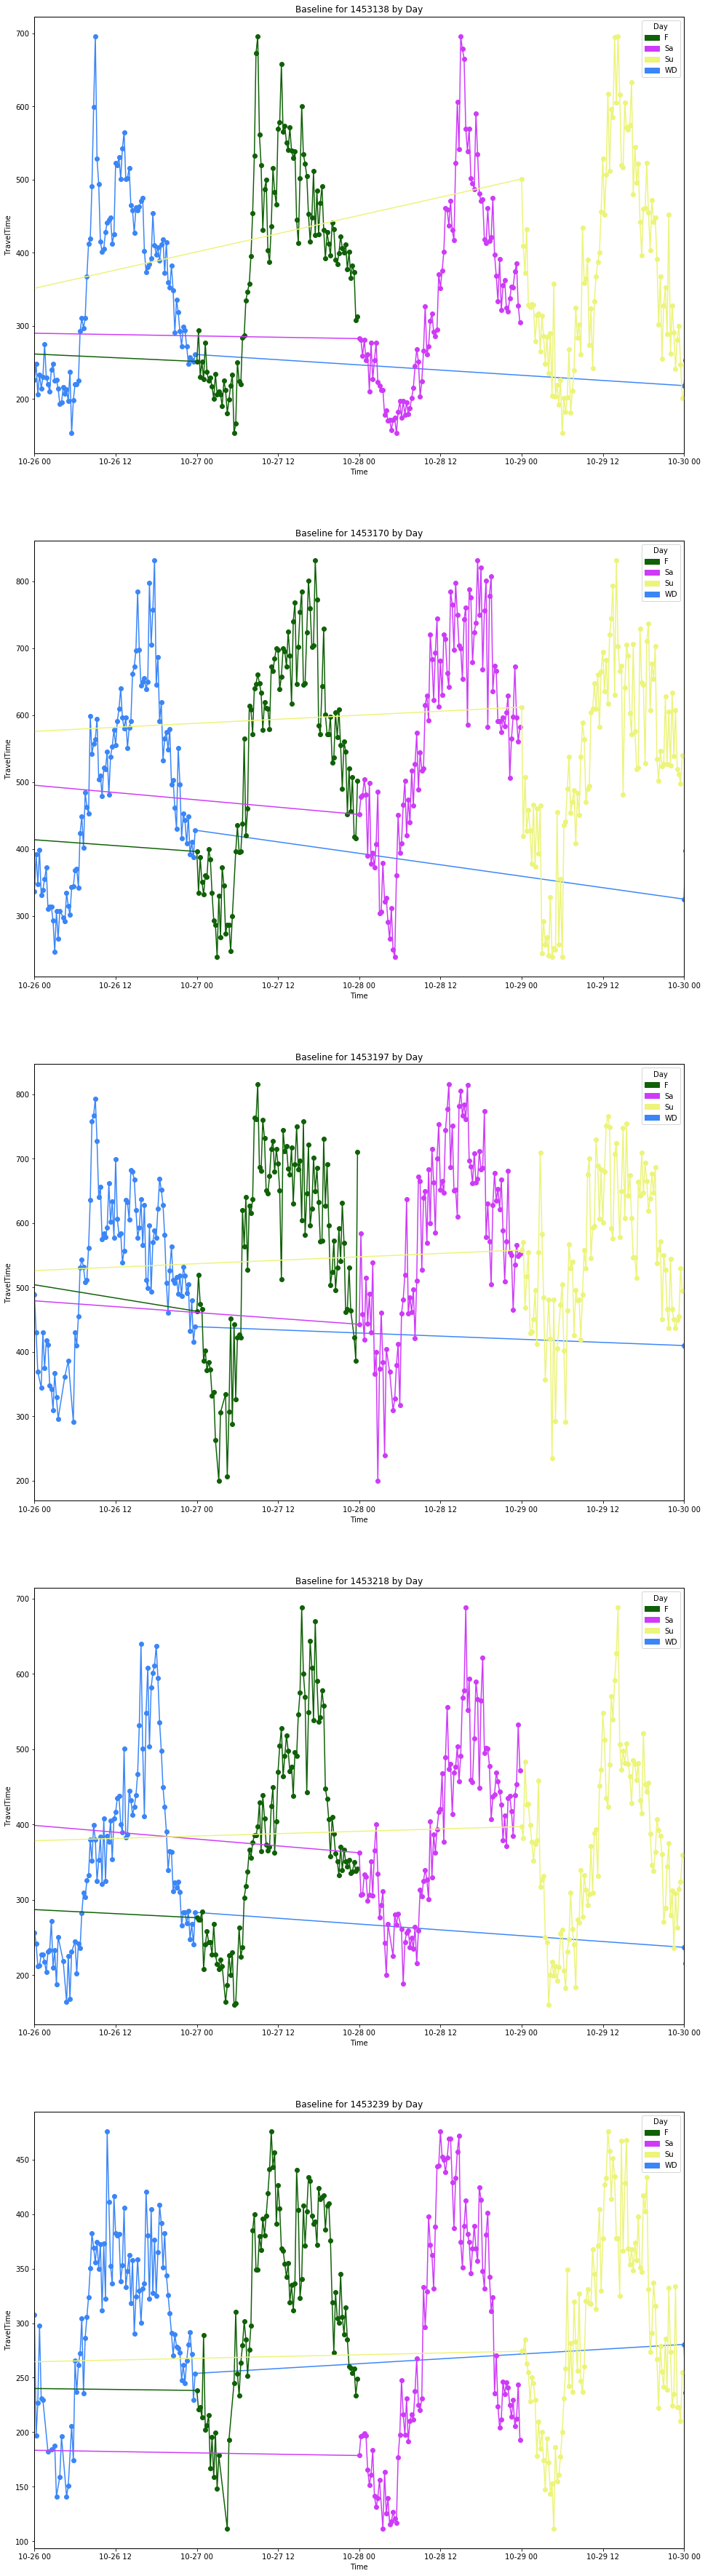

In [115]:
plot_base(observations_15)

In [122]:
sql_30 = '''
WITH yr as (
    SELECT EXTRACT(YEAR FROM datetime_bin) as year, 
        analysis_id, 
        datetime_bin::time as time, 
        percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.travel_time) as yr_tt,
        EXTRACT(isodow FROM datetime_bin) as weekday,
        aa.report_name

    FROM dt_30min_agg bt

    GROUP BY analysis_id, 
        datetime_bin::time, 
        EXTRACT(YEAR FROM datetime_bin),
        EXTRACT(ISODOW FROM datetime_bin))

SELECT bt.tt, 
       yr.yr_tt, 
       bt.datetime_bin, 
       bt.analysis_id,
       yr.weekday
FROM bluetooth.aggr_15min bt
	INNER JOIN yr ON (yr.analysis_id = bt.analysis_id AND 
		EXTRACT('year' FROM bt.datetime_bin) = yr.year AND 
		bt.datetime_bin::time = yr.time) AND 
		EXTRACT('isodow' FROM bt.datetime_bin) = yr.weekday
	INNER JOIN bluetooth.all_analyses aa ON (bt.analysis_id = aa.analysis_id)
WHERE left(aa.report_name, 4) = 'DT-0'
'''
observations_30 = pandasql.read_sql(sql, con)

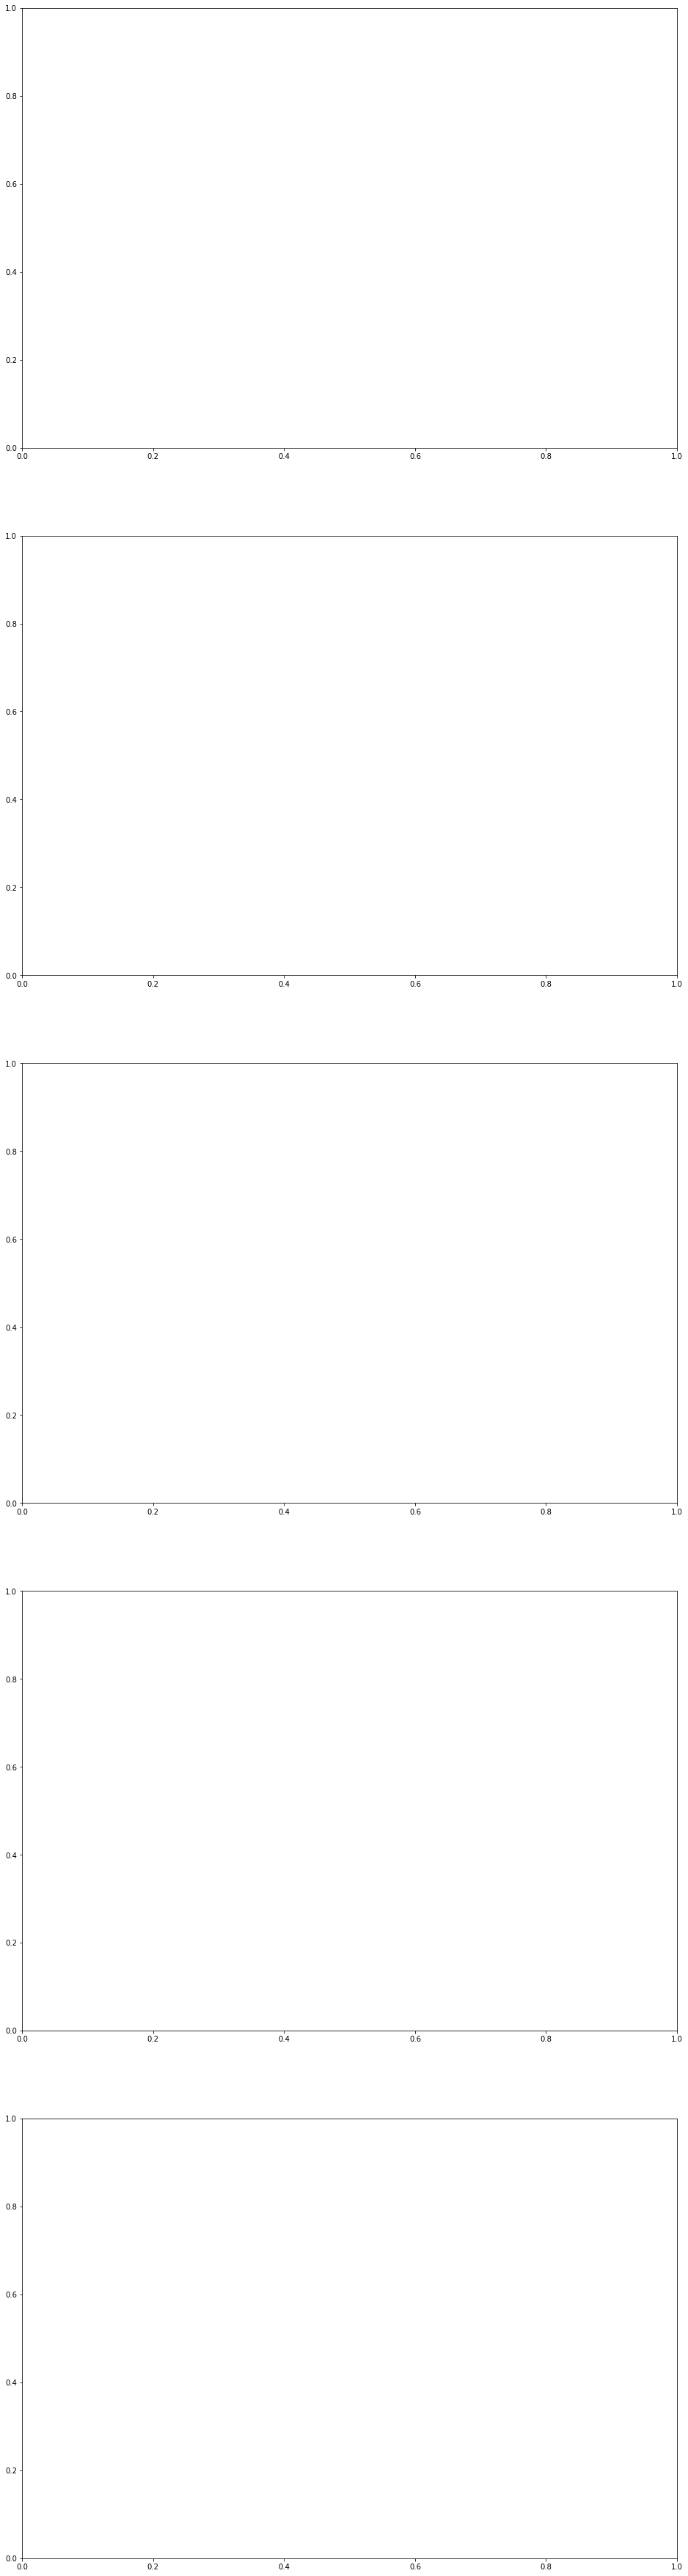

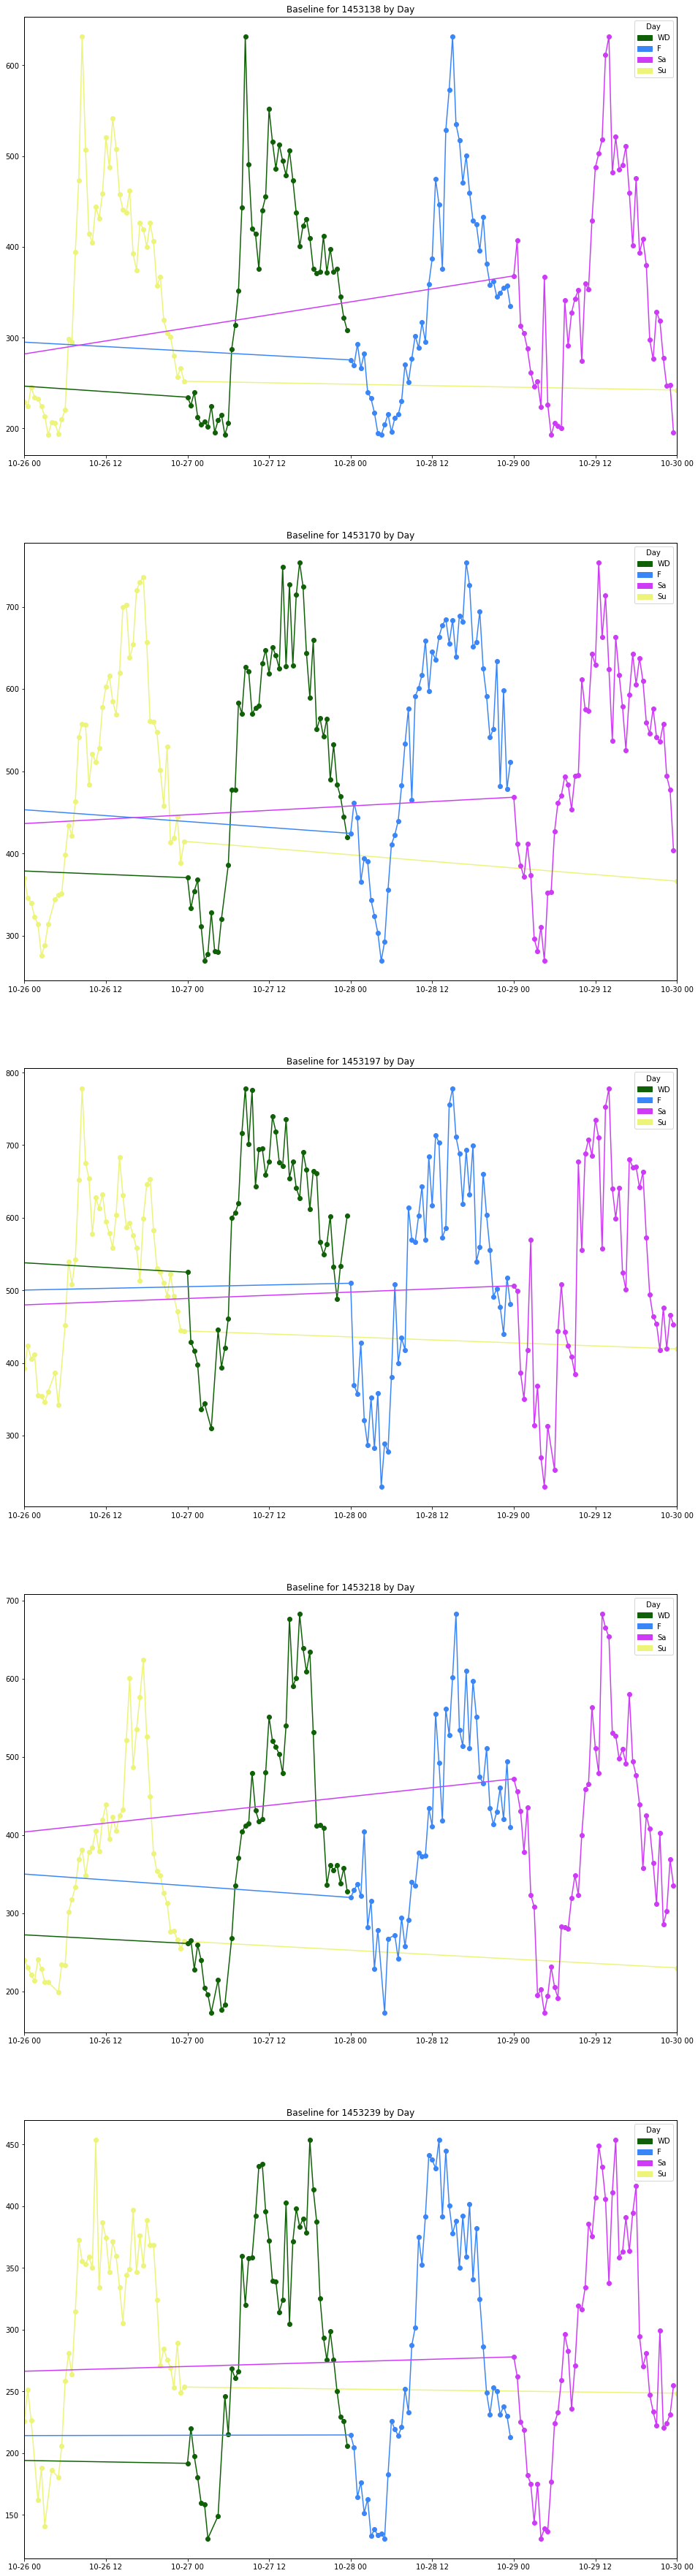

In [108]:
plot_base(obsrvations_30)

In [136]:
def WOY(x, W):
    return x.weekofyear == W

In [146]:
weeks = {W : observations[observations_30.datetime_bin.apply(WOY, args = (W,))]
 for W in observations_30.datetime_bin.apply(lambda x : x.weekofyear).unique()}

In [154]:
len(weeks.keys())

8

In [ ]:
fig, ax = plt.subplots(len(weeks.keys()),1)
for i, week in enumerate(weeks):
    ax.plot
    #make some graphs

In [105]:
colors = ['#004B85','#F2756D']

In [137]:
def getfig(analysis_id, week):
    fig, BT = plt.subplots(figsize = (16,8))
    year = BT.twinx()
    year = BT.twiny()
    BT.plot_date(x = segments[analysis_id]['datetime_bin'],
                y = segments[analysis_id]['tt'],
                xdate = True,
                ydate = False,
                c = colors[0],
                fmt = '-o')
    year.plot_date(x = segments[analysis_id]['datetime_bin'],
                  y = segments[analysis_id]['yr_tt'],
                  xdate = True,
                  ydate = False,
                  c = colors[1],
                  fmt = '-o')
    
    BT.xaxis.set_label_text('Timestamp')
    BT.yaxis.set_label_text('Travel Time')
    
    #BT.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonth=range(1,13,6)))
    
    plt.title('Bluetooth VS Average Day on ' + str(analysis_id))
    
    BT.legend(loc = 'upper right')
    year.legend(loc= 'upper left')
    
    year.get_xaxis().set_visible(False)
    
    return fig

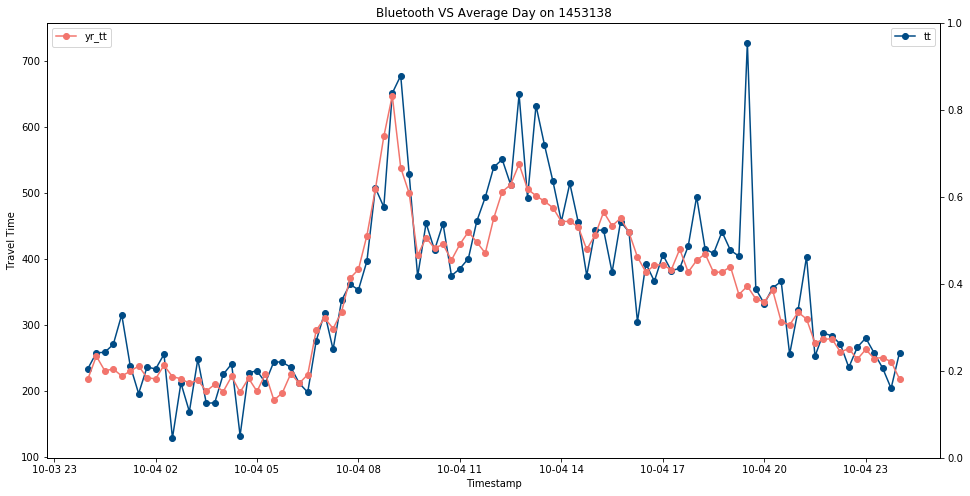

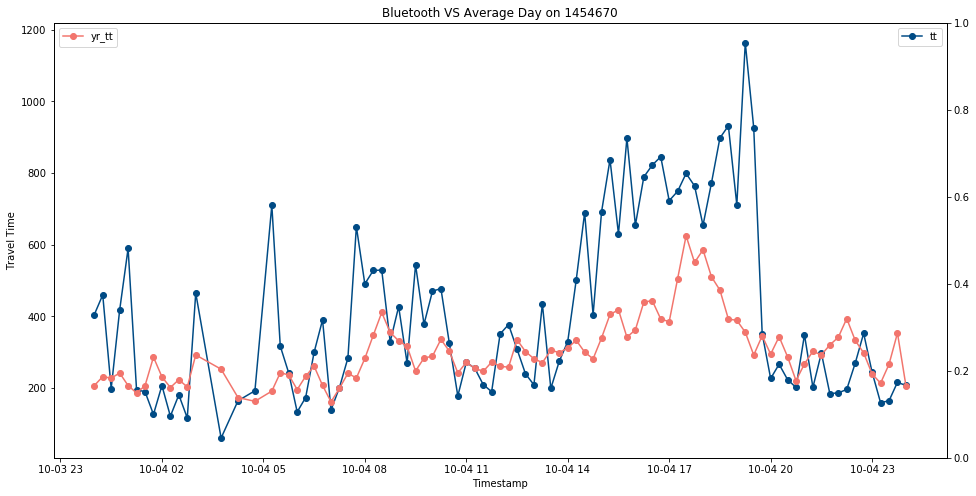

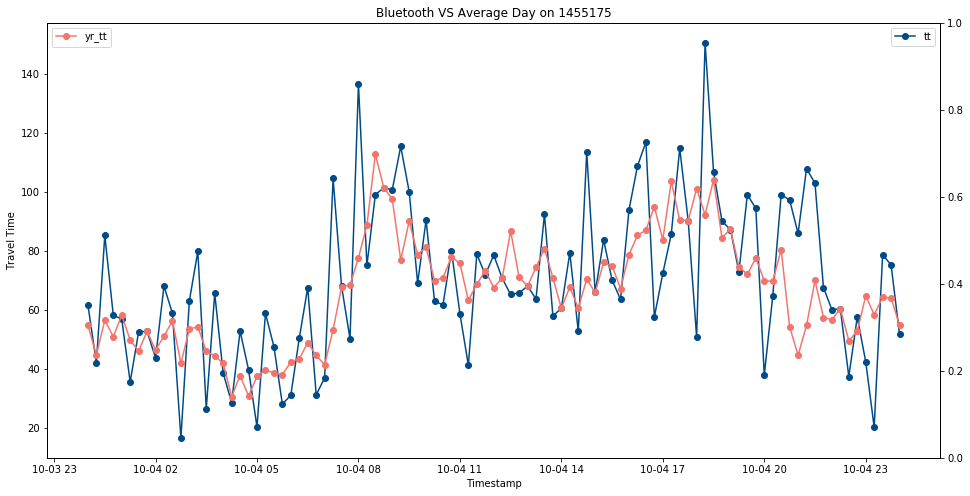

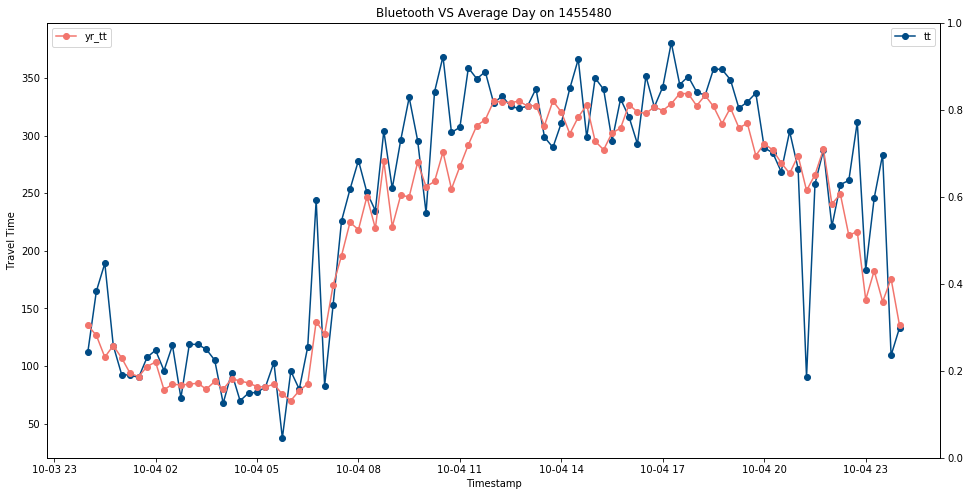

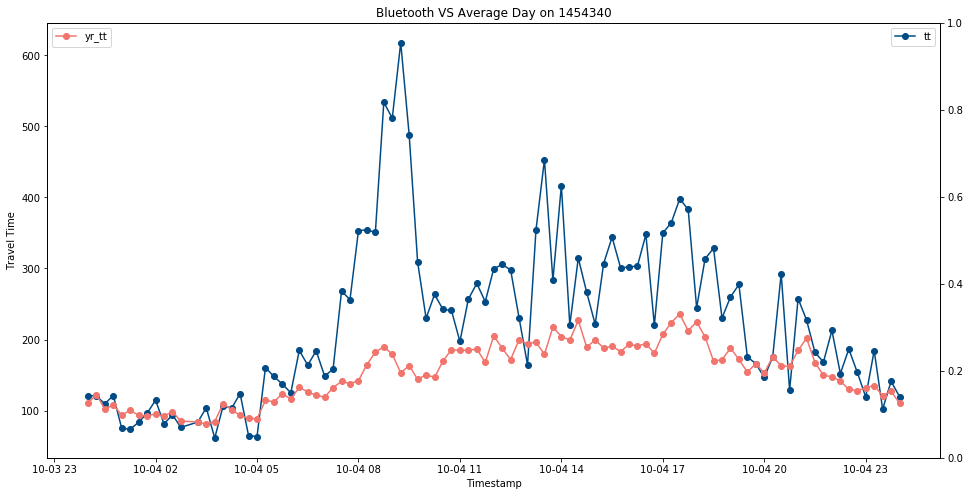

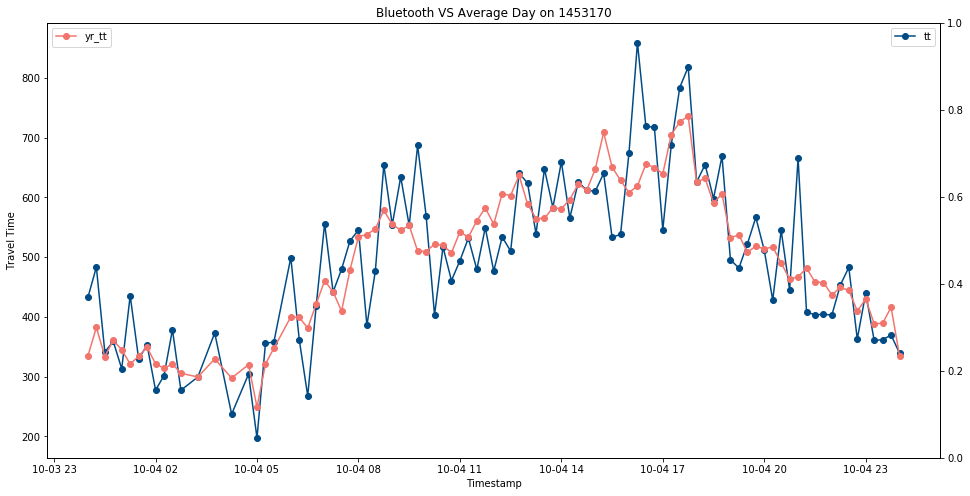

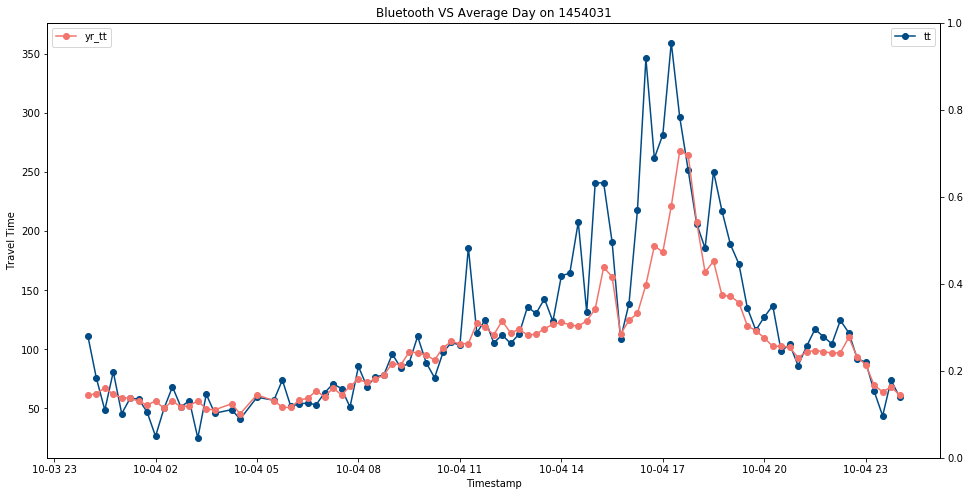

In [138]:
for i, analysis_id in enumerate(segments):
    plt.show(getfig(analysis_id))
    if i > 5:
        break

In [120]:
observations['report_name']

KeyError: 'report_name'